# SOM model comparison

Compute Md* to compare various GIFs fitted to DRN SOM cells.

As of 2019.03.18 the GIF and iGIF perform better than the KGIF and CaGIF. For the KGIF and CaGIF worse performance seems to be associated with stronger correlations between pre-spike voltage and $V_{reset}$. Suggests that KGIF/CaGIF performance might improved by adding a dynamic reset rule $V_{reset} = m V_{pre} + b$ with $m$ and $b$ trivially extracted from traces used to fit the models.

## Import modules

In [1]:
from __future__ import division

import os; os.chdir(os.path.join('..', '..', '..'))
print os.getcwd()

/Users/eharkin/Documents/School/Grad work/Thesis/Experiments/GIF fitting/GIF fitting project/GIFFittingToolbox


In [2]:
import pickle

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import pandas as pd
import seaborn as sns
from scipy import stats

from src.GIF import GIF
from src.CalciumGIF import CalciumGIF
from src.AugmentedGIF import AugmentedGIF
from src.Tools import gagProcess
from src import pltools

## Load models and data

Models are fitted to only 'good' cells. ('Good' cells are defined based on drift and instrinsic reliability based on the test set. See `figs/scripts/gaba_neurons/GABA_fit.py` for implementation.) `experiments` loaded from `gaba_goodcells.ldat` include only good cells.

**Note:** Models and experiments are currently *assumed* to be in the same order without checking. This is risky because if the ith cell doesn't correspond to the ith model this would go undetected and show up only as suboptimal model performance.

In [3]:
DATA_PATH = os.path.join('data', 'processed', 'GABA_fastnoise')

with open(os.path.join(DATA_PATH, 'gaba_goodcells.ldat'), 'rb') as f:
    experiments = pickle.load(f)

In [4]:
MOD_PATH = os.path.join('data', 'models', 'GABA')

mods = {}

with open(os.path.join(MOD_PATH, 'gaba_gifs.mod'), 'rb') as f:
    mods['GIF'] = pickle.load(f)
    f.close()
    
with open(os.path.join(MOD_PATH, 'gaba_igifs.mod'), 'rb') as f:
    mods['iGIF'] = pickle.load(f)
    f.close()
    
with open(os.path.join(MOD_PATH, 'gaba_kgifs.mod'), 'rb') as f:
    mods['KGIF'] = pickle.load(f)
    f.close()
    
with open(os.path.join(MOD_PATH, 'gaba_cagifs.mod'), 'rb') as f:
    mods['CaGIF'] = pickle.load(f)
    f.close()

## Compare model performance using Md*

Compare spiketrain predictions using Md* at a specified precision. Larger values are better.

Hypothesis is that model with calcium current will perform better in some cells, whereas model with IA will perform better in others.

In [5]:
# Set benchmark parameters.
precision = 4.    # Window within which to consider spikes coincident. Units of ms.
nb_rep = 100      # Number of spiketrains to realize. Usually set to 500.

# Initialize structures to hold output.
Md_vals = pd.DataFrame(columns = np.concatenate((['Cell ID'], mods.keys())))
predictions = pd.DataFrame(columns = np.concatenate((['Cell ID'], mods.keys())))

for i, expt in enumerate(experiments):
    print '\rComputing Md* {:.1f}%'.format(100 * i / len(experiments)),
    
    Md_row = {'Cell ID': expt.name}
    preds_row = {'Cell ID': expt.name}
    
    with gagProcess():
        for key in mods.keys():
            preds_row[key] = expt.predictSpikes(mods[key][i], nb_rep = nb_rep)
            Md_row[key] = preds_row[key].computeMD_Kistler(precision, 0.1)
        
    Md_vals = Md_vals.append(Md_row, ignore_index = True)
    predictions = predictions.append(preds_row, ignore_index = True)

print '\nDone!'
    
del Md_row, preds_row

Computing Md* 90.9%          
Done!


In [6]:
Md_vals.head()

,Cell ID,GIF,KGIF,iGIF,CaGIF
0,DRN351,0.307829,0.235976,0.787721,0.248095
1,DRN354,0.826043,0.810092,0.894708,0.502883
2,DRN355,0.540923,0.837426,0.874627,0.839114
3,DRN357,0.829372,0.818788,0.882798,0.571739
4,SOM_14_LW,0.823353,0.844855,0.845119,0.836838


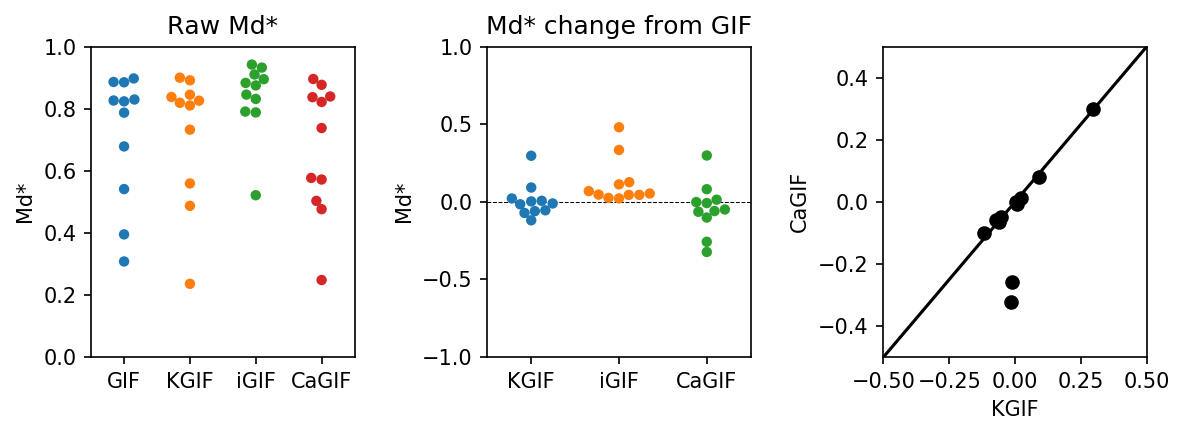

In [7]:
# Melt dataframe for plotting.
absMd_forplot = Md_vals.melt(
    id_vars = 'Cell ID', value_vars = mods.keys(), 
    var_name = 'Model', value_name = 'Md*'
)

relMd_forplot = (
        Md_vals[[k for k in mods.keys() if k != 'GIF']] 
        - np.tile(Md_vals['GIF'][:, np.newaxis], (1, Md_vals.shape[1] - 2))
    ).melt(
    var_name = 'Model', value_name = 'Md*'
)

# Make plot.
plt.figure(figsize = (8, 3), dpi = 150)

plt.subplot(131)
plt.title('Raw Md*')
plt.ylim(0, 1)
"""plt.plot(
    [0.2 * np.ones(Md_vals.shape[0]), 0.8 * np.ones(Md_vals.shape[0])],
    [Md_vals['GIF'], Md_vals['CaGIF']],
    '-', color = 'gray', lw = 2, alpha = 0.2
)"""
sns.swarmplot(y = 'Md*', x = 'Model', data = absMd_forplot, size = 5)
plt.xlabel('')

plt.subplot(132)
plt.title('Md* change from GIF')
plt.axhline(0, ls = '--', color = 'k', lw = 0.5)
plt.ylim(-1, 1)
sns.swarmplot(y = 'Md*', x = 'Model', data = relMd_forplot, size = 5)
plt.xlabel('')

plt.subplot(133)
plt.plot([-1, 1], [-1, 1], 'k-')
plt.plot(
    relMd_forplot.loc[relMd_forplot['Model'] == 'KGIF', 'Md*'],
    relMd_forplot.loc[relMd_forplot['Model'] == 'CaGIF', 'Md*'],
    'ko'
)
plt.ylabel('CaGIF')
plt.xlabel('KGIF')
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)

plt.tight_layout()

plt.show()

# Clean up.
del absMd_forplot, relMd_forplot

A bit disappointing. Looks like the KGIF and CaGIF don't really do better than the vanilla GIF on average. Even worse, the change in performance relative to the GIF is highly correlated for the KGIF and CaGIF! Seems like $I_T$ isn't improving the model, and most of the improvement from the KGIF and CaGIF may be from Kslow...

## Inspect model

Wonder whether the estimated values of particular CaGIF/KGIF coefficients are associated with better or worse performance.

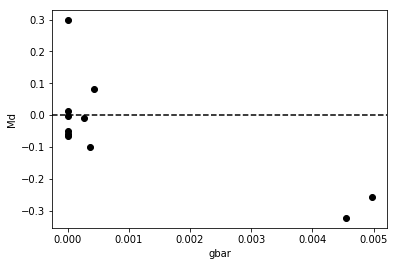

In [8]:
gbars = [m.gbar_K1 for m in mods['CaGIF']]

plt.figure()
plt.plot(gbars, Md_vals['CaGIF'] - Md_vals['GIF'], 'ko')
plt.axhline(0, color = 'k', ls = '--')
plt.xlabel('gbar')
plt.ylabel('Md')
plt.show()

In [9]:
gbars

[7.519984129616576e-20,
 0.004545232220977634,
 1.1115134033517741e-27,
 0.004975510646138076,
 4.6223758752141154e-33,
 1.5420803870666876e-20,
 2.753620548118079e-23,
 0.00037088990390975407,
 0.00043061414535533986,
 1.459065921052423e-26,
 0.0002698492953663834]

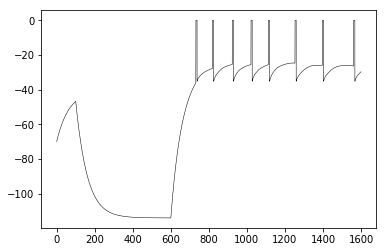

In [10]:
mod_ = mods['CaGIF']
curr_step = np.concatenate((np.zeros(1000), -0.1 * np.ones(5000), 0.02 * np.ones(10000)))

t, V, eta, V_T, spks = mods['CaGIF'][7].simulate(curr_step, -70.)

plt.figure()
plt.plot(t, V, 'k-', lw = 0.5)
plt.show()

In [11]:
def plotModelSample(model, input_vec, no_reps = 10, ax = None):
    if ax is None:
        ax = plt.gca()
        
    tmp_spec = gs.GridSpecFromSubplotSpec(3, 1, ax, height_ratios = [0.2, 1, 0.6], hspace = 0)
    
    plt.subplot(tmp_spec[2, :])
    for i in range(no_reps):
        t, V, eta, V_T, spks = model.simulate(input_vec, model.El)
        plt.plot(spks, i * np.ones_like(spks), 'k|', markersize = 3)
    plt.yticks([])
    plt.xlim(t[0], t[-1])
    pltools.hide_border('trl')
    
    plt.subplot(tmp_spec[0, :])
    plt.title(str(type(model)).split('.')[-1][:-2])
    plt.plot(t, input_vec, '-', color = 'gray', lw = 0.5)
    plt.xticks([])
    plt.xlim(t[0], t[-1])
    pltools.hide_border('rtb')
    
    plt.subplot(tmp_spec[1, :])
    plt.plot(t, V, 'k-', lw = 0.5)
    plt.xticks([])
    plt.xlim(t[0], t[-1])
    pltools.hide_border('rtb')

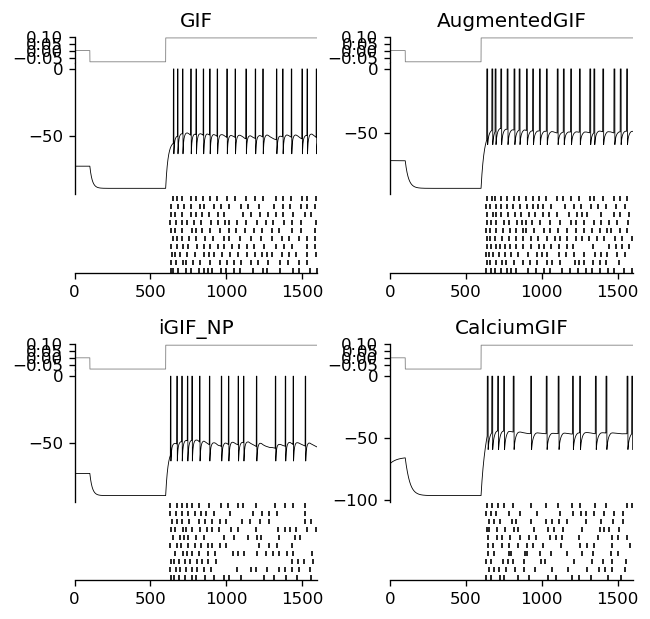

In [12]:
cell_no = 3
curr_step = np.concatenate((np.zeros(1000), -0.08 * np.ones(5000), 0.09 * np.ones(10000)))

motr_outer_spec = gs.GridSpec((len(mods) + 1)//2, 2, hspace = 0.3, wspace = 0.3)

plt.figure(figsize = (6, 6), dpi = 120)

for i, key in enumerate(mods.keys()):
    plt.subplot(motr_outer_spec[i // 2, i % 2])
    plotModelSample(mods[key][cell_no], curr_step)
    

plt.show()

In [13]:
print mods['GIF'][cell_no].name
mods['CaGIF'][cell_no].printParameters()
mods['KGIF'][cell_no].printParameters()
print mods['KGIF'][cell_no].h_tau

DRN357

-------------------------
GIF model parameters:
-------------------------
tau_m (ms):	25.671
R (MOhm):	323.748
C (nF):		0.079
gl (nS):	0.003089
El (mV):	-70.709
Tref (ms):	6.500
Vr (mV):	-59.233
Vt* (mV):	-64.426
DV (mV):	3.689
gk1 (ns):	0.0050
gk2 (ns):	0.0169
-------------------------


-------------------------
GIF model parameters:
-------------------------
tau_m (ms):	21.523
R (MOhm):	270.886
C (nF):		0.079
gl (nS):	0.003692
El (mV):	-71.714
Tref (ms):	6.500
Vr (mV):	-59.183
Vt* (mV):	-67.710
DV (mV):	2.321
gk1 (ns):	0.0000
gk2 (ns):	0.0188
-------------------------

66.16417768614114


## Inspect correlation between pre and post-spk voltage

Sometimes the Vreset might be correlated with the pre-spk voltage, but none of the models here use this information. First I'll check the raw traces to see whether there is indeed a correlation between pre- and post-spk voltage.

In [14]:
def extractPrePost(trace, dt_before = 1.5, dt_after = 4.0):
    """Extract voltage just before spks and at reset.
    
    Returns 2D array with voltage immediately before spk in first col and voltage
    immediately after in second col.
    """
    
    dt_before_ind = int(dt_before / trace.dt)
    dt_after_ind = int(dt_after / trace.dt)
    
    ROI_ind = trace.getROI()
    
    pairs = []
    
    for s in trace.spks:
        if s in ROI_ind and s > dt_before_ind and s < (len(trace.V) - dt_after_ind):
            pairs.append([trace.V[s - dt_before_ind], trace.V[s + dt_after_ind]])
            
    return np.array(pairs)

In [15]:
# Extract the pre/post spike voltage from all experiments.
pairs = []
for expt in experiments:
    pairs_tmp = []
    for tr in expt.trainingset_traces:
        pairs_tmp.append(extractPrePost(tr))
    pairs.append(np.concatenate(pairs_tmp, axis = 0))

/Users/eharkin/miniconda3/envs/pozz/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/eharkin/miniconda3/envs/pozz/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 432x288 with 0 Axes>

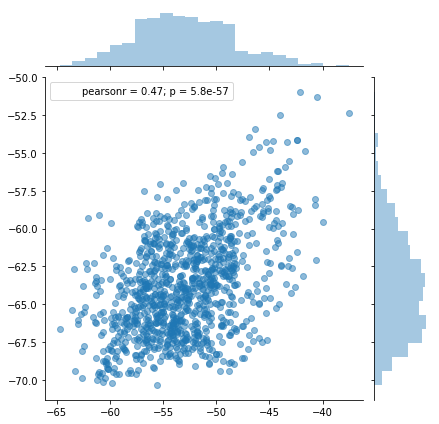

In [16]:
# Plot an example.
cell_no = 3

plt.figure()
sns.jointplot(x = pairs[cell_no][:, 0], y = pairs[cell_no][:, 1], alpha = 0.5)
plt.show()

In [17]:
# Extract correlation coefficients across cells.
corr_coeffs = []
post_var = []
for pair_ in pairs:
    corr_coeffs.append(stats.pearsonr(pair_[:, 0], pair_[:, 1])[0])
    post_var.append(np.var(pair_[:, 1]))
    
corr_coeffs = np.array(corr_coeffs)
post_var = np.array(post_var)

In [18]:
def plotMdVreset(Md_values, reset_correlation, reset_variance, 
                 r2_ax, unexplained_ax, model_name = None, label_xaxis = False):
    """Standard representation of relationship between Vreset predictability and Md*
    
    rho refers to the nonparametric Spearman correlation.
    
    Inputs:
        Md_values: float vector
            --  Md* values from a given model. Should range [0, 1].
        reset_correlation: float vector
            --  Correlation coefficient of Vreset with V immediately before spike for each cell.
        reset_variance: float vector
            --  Total variance of Vreset for each cell.
        r2_ax: axes object
            --  Axes on which to plot relationship between r2 and Md*.
        unexplained_ax: axes object
            --  Axes on which to plot relationship between unexplained variance and Md*.
        model_name: string (optional)
            --  Name of model used to generate Md*.
        label_xaxis: bool (optional)
            --  Toggle labeling of x axis. If False, xticklabels are stripped.
            
    Returns: nothing
    """
    
    if model_name is None:
        model_name = ''
    
    r2 = reset_correlation**2
    
    r2_ax.text(
        0.05, 0.05,
        r'$\rho = {:.2f}, p = {:.2f}$'.format(*stats.spearmanr(r2, Md_values)),
        transform = r2_ax.transAxes
    )
    r2_ax.plot(
        r2, Md_values, 
        'ko', markeredgecolor = 'gray', clip_on = False
    )
    r2_ax.set_ylim(0, 1)
    r2_ax.set_xlim(0, 1)
    r2_ax.set_ylabel(model_name + ' $M_d^*$')
    
    unexplained_variance = (1-r2) * reset_variance
    unexplained_ax.text(
        0.05, 0.05,
        r'$\rho = {:.2f}, p = {:.2f}$'.format(*stats.spearmanr(unexplained_variance, Md_values)),
        transform = unexplained_ax.transAxes
    )
    unexplained_ax.plot(
        unexplained_variance, Md_values, 
        'ko', markeredgecolor = 'gray', clip_on = False
    )
    unexplained_ax.set_ylim(0, 1)
    unexplained_ax.set_xlim(0, unexplained_ax.get_xlim()[1])
    unexplained_ax.set_yticklabels([])
    
    if label_xaxis:
        r2_ax.set_xlabel(r'$R^2\ V_{pre}\ \mathrm{vs.}\ V_{post}$')
        unexplained_ax.set_xlabel(
            r'Unexplained variance ($\mathrm{mV}^2$)' '\n' 
            r'$(1 - R^2) \times \mathrm{Var}[V_{reset}]$'
        )
    else:
        r2_ax.set_xticklabels([])
        unexplained_ax.set_xticklabels([])

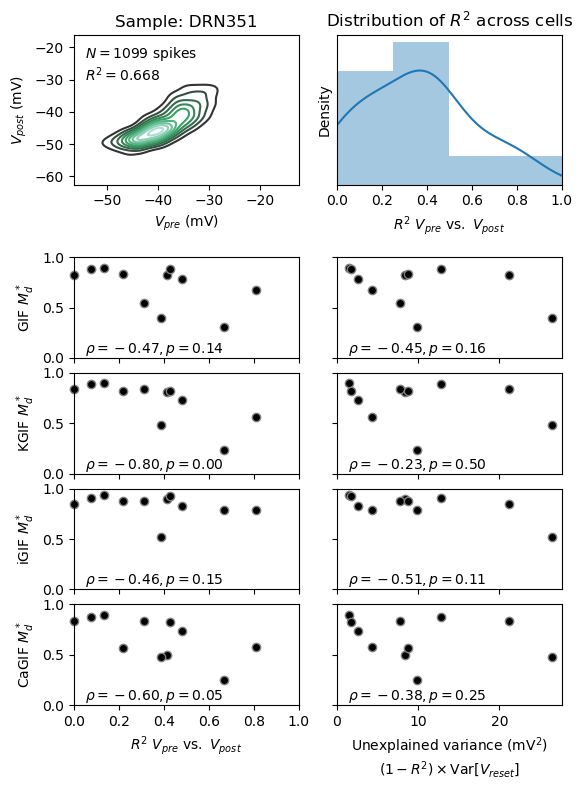

In [19]:
# Plot a summary.
vreset_outer_spec = gs.GridSpec(2, 2, height_ratios = [1, 3])
vreset_mdplots_spec = gs.GridSpecFromSubplotSpec(len(mods.keys()), 2, vreset_outer_spec[1, :], hspace = 0.15)

plt.figure(figsize = (6, 8), dpi = 100)

plt.subplot(vreset_outer_spec[0, 0])
example_no = 0
plt.title('Sample: {}'.format(experiments[example_no].name))
sns.kdeplot(pairs[example_no][:, 0], pairs[example_no][:, 1])
plt.text(
    0.05, 0.95, '$N = {}$ spikes\n'.format(pairs[example_no].shape[0]) +
    '$R^2 = {:.3f}$'.format(stats.pearsonr(pairs[example_no][:, 0], pairs[example_no][:, 1])[0]**2),
    va = 'top', transform = plt.gca().transAxes
)
plt.xlabel('$V_{pre}$ (mV)')
plt.ylabel('$V_{post}$ (mV)')

plt.subplot(vreset_outer_spec[0, 1])
plt.title('Distribution of $R^2$ across cells')
sns.distplot(corr_coeffs ** 2, bins = [0, 0.25, 0.5, 0.75, 1.])
plt.xlim(0, 1)
plt.yticks([])
plt.ylabel('Density')
plt.xlabel(r'$R^2\ V_{pre}\ \mathrm{vs.}\ V_{post}$')

# Plot the relationship between Md* and Vreset R^2 for each model.
for i, key in enumerate(mods.keys()):
    if i == len(mods.keys()) - 1:
        label_x = True
    else:
        label_x = False
        
    plotMdVreset(
        Md_vals[key], corr_coeffs, post_var,
        plt.subplot(vreset_mdplots_spec[i, 0]), plt.subplot(vreset_mdplots_spec[i, 1]),
        model_name = key, label_xaxis = label_x
    )

plt.tight_layout()

plt.show()

We see above that in an example SOM cell the post-spike reset voltage is highly correlated with the voltage just before the spike (top left). If we calculate this correlation based on the spikes in the training data for each cell, we find that most of the time the post-spike reset is weakly to moderately correlated with the pre-spike voltage (top right).

The bottom part of the figure shows the relationship between the strength of this correlation and model performance for each model tested. (Rho denotes nonparametric Spearman correlation.) In the left column, we see that the Vreset correlation is associated with worse model performance mainly for the KGIF and CaGIF. In the right column, we see that the amount of unexplained variance in Vreset (that is, the noise inherent in the measured Vreset after controlling for any effect of Vpre) mainly impacts the performance the GIF and iGIF.

These results imply that the GIF and iGIF may not benefit as much from a voltage-dependent spike reset rule as the KGIF and CaGIF.